In [ ]:
#박스 그려보기기

import os
import json
import cv2

# Define directories
label_dir = "/data/ephemeral/home/MCG/data/train/outputs_json"
input_dir = "/data/ephemeral/home/MCG/data/train/DCM"
output_dir = "/data/ephemeral/home/MCG/yolo/annotated_images"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Calculate bounding box for a set of points
def calculate_bounding_box(points):
    if not points:
        return None
    x_values = [p[0] for p in points]
    y_values = [p[1] for p in points]
    return min(x_values), min(y_values), max(x_values), max(y_values)

# Process each patient's images
for patient_id in os.listdir(label_dir):
    patient_label_path = os.path.join(label_dir, patient_id)
    patient_image_path = os.path.join(input_dir, patient_id)
    
    if not os.path.isdir(patient_label_path):
        continue

    for json_file in os.listdir(patient_label_path):
        if json_file.endswith(".json"):
            # Load JSON data
            json_path = os.path.join(patient_label_path, json_file)
            with open(json_path, "r") as f:
                data = json.load(f)

            # Prepare image path and output path
            image_name = json_file.replace(".json", ".png")
            image_path = os.path.join(patient_image_path, image_name)
            output_path = os.path.join(output_dir, f"{patient_id}_{image_name}")
            
            # Skip if the corresponding image does not exist
            if not os.path.isfile(image_path):
                continue

            # Read the image using OpenCV
            image = cv2.imread(image_path)
            if image is None:
                continue

            # Initialize groups
            finger_points = []
            radius_ulna_points = []
            others_points = []

            # Categorize points based on labels
            for annotation in data['annotations']:
                label = annotation['label']
                points = annotation['points']
                
                if 'finger' in label.lower():
                    finger_points.extend(points)
                elif label in ['Radius', 'Ulna']:
                    radius_ulna_points.extend(points)
                else:
                    others_points.extend(points)

            # Calculate bounding boxes for each group
            finger_box = calculate_bounding_box(finger_points)
            radius_ulna_box = calculate_bounding_box(radius_ulna_points)
            others_box = calculate_bounding_box(others_points)

            # Draw bounding boxes on the image
            if finger_box is not None:
                x_min, y_min, x_max, y_max = finger_box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blue for Fingers
            if radius_ulna_box is not None:
                x_min, y_min, x_max, y_max = radius_ulna_box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green for Radius & Ulna
            if others_box is not None:
                x_min, y_min, x_max, y_max = others_box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  # Red for Others

            # Save the annotated image
            cv2.imwrite(output_path, image)


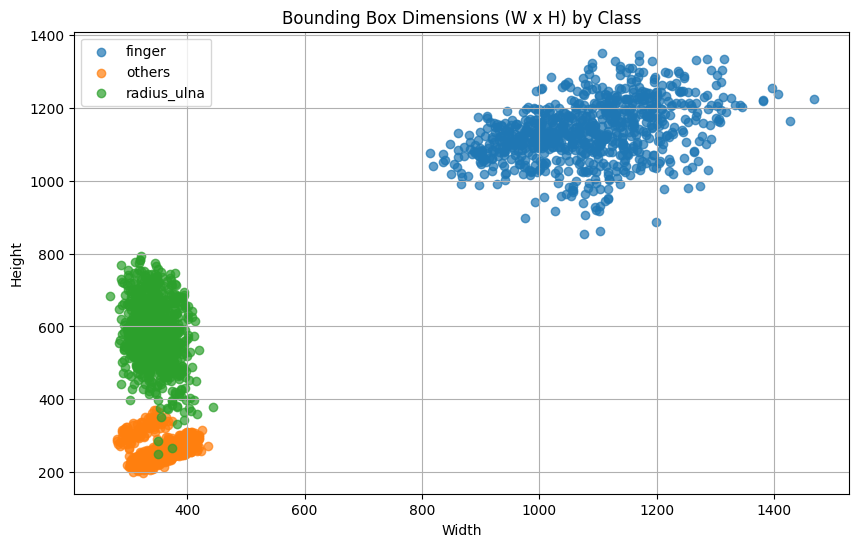

Maximum Width and Height for each Class:
             Width  Height
Class                     
finger        1468    1352
others         435     371
radius_ulna    444     793


In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define directories
label_dir = "/data/ephemeral/home/MCG/data/train/outputs_json"

# Calculate bounding box for a set of points
def calculate_bounding_box(points):
    if not points:
        return None
    x_values = [p[0] for p in points]
    y_values = [p[1] for p in points]
    return min(x_values), min(y_values), max(x_values), max(y_values)

# Store bounding box dimensions for EDA
bounding_boxes = {"Class": [], "Width": [], "Height": []}

# Process each patient's labels
for patient_id in os.listdir(label_dir):
    patient_label_path = os.path.join(label_dir, patient_id)
    if not os.path.isdir(patient_label_path):
        continue

    for json_file in os.listdir(patient_label_path):
        if json_file.endswith(".json"):
            # Load JSON data
            json_path = os.path.join(patient_label_path, json_file)
            with open(json_path, "r") as f:
                data = json.load(f)

            # Initialize groups
            finger_points = []
            radius_ulna_points = []
            others_points = []

            # Categorize points based on labels
            for annotation in data['annotations']:
                label = annotation['label']
                points = annotation['points']
                
                if 'finger' in label.lower():
                    finger_points.extend(points)
                elif label in ['Radius', 'Ulna']:
                    radius_ulna_points.extend(points)
                else:
                    others_points.extend(points)

            # Calculate bounding boxes for each group
            finger_box = calculate_bounding_box(finger_points)
            radius_ulna_box = calculate_bounding_box(radius_ulna_points)
            others_box = calculate_bounding_box(others_points)

            # Store the dimensions of each box
            if finger_box is not None:
                x_min, y_min, x_max, y_max = finger_box
                bounding_boxes["Class"].append("finger")
                bounding_boxes["Width"].append(x_max - x_min)
                bounding_boxes["Height"].append(y_max - y_min)

            if radius_ulna_box is not None:
                x_min, y_min, x_max, y_max = radius_ulna_box
                bounding_boxes["Class"].append("radius_ulna")
                bounding_boxes["Width"].append(x_max - x_min)
                bounding_boxes["Height"].append(y_max - y_min)

            if others_box is not None:
                x_min, y_min, x_max, y_max = others_box
                bounding_boxes["Class"].append("others")
                bounding_boxes["Width"].append(x_max - x_min)
                bounding_boxes["Height"].append(y_max - y_min)

# Convert bounding box data into a DataFrame
df = pd.DataFrame(bounding_boxes)

# 1. Plot scatter plot for bounding box dimensions
plt.figure(figsize=(10, 6))
for class_name, group_data in df.groupby("Class"):
    plt.scatter(group_data["Width"], group_data["Height"], label=class_name, alpha=0.7)

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Bounding Box Dimensions (W x H) by Class")
plt.legend()
plt.grid(True)
plt.show()

# 2. Find the largest W and H for each class
max_dimensions = df.groupby("Class")[["Width", "Height"]].max()
print("Maximum Width and Height for each Class:")
print(max_dimensions)
